# Template for Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

In [1]:
import os, sys, wave, struct
import scipy.signal as sgn
import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write
import time

## Functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def plot_response(fs, w, h, title):
    "Utility function to plot response functions"
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))
    ax.set_ylim(-60, 10)
    ax.set_xlim(0, 0.5*fs)
    ax.grid(True)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain (dB)')
    ax.set_title(title)



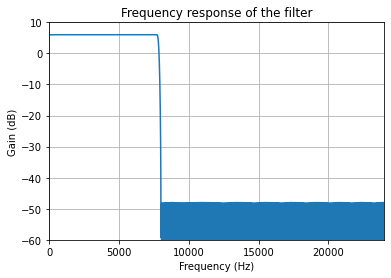

In [3]:
## Question 1 ###################### 
fs = 48000.0       # Sample rate, Hz
cutoff = fs/6.   # Desired cutoff frequency, Hz
trans_width = 275  # Width of transition from pass band to stop band, Hz
numtaps = 500      # Size of the FIR filter.
h = sgn.remez(numtaps, [0, cutoff - trans_width, cutoff, 0.5*fs], [2, 0], Hz=fs)
w, z = sgn.freqz(h, [1], worN=2000)
plot_response(fs, w, z, "Frequency response of the filter")

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [43]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [44]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [45]:
play = False
if play :
    play_sound(sound) 

In [46]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

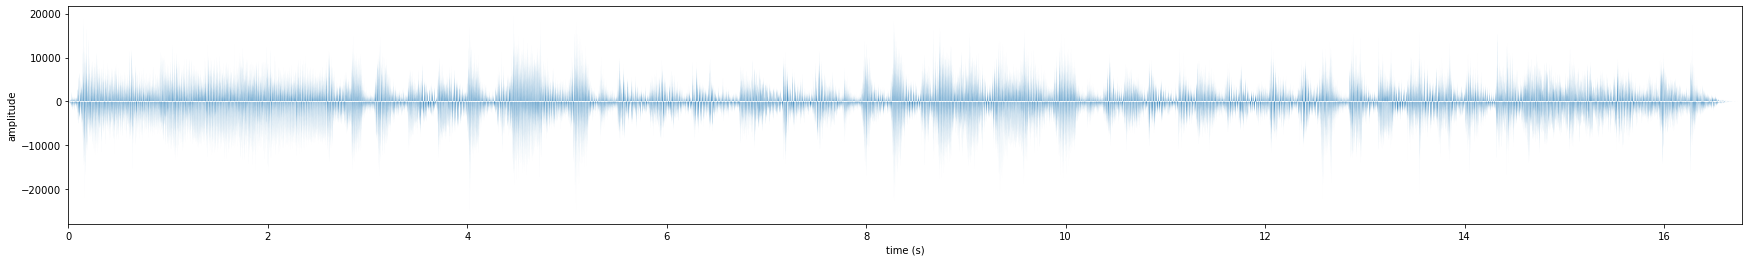

In [47]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

plot_sound(x,times)

In [48]:
## Question 2 ###################### 
t0 = time.time()       # used for question 4

y = np.zeros(2*len(x)) # insertion of
y[0:len(y):2] = x      # zeros 

y = sgn.lfilter(h,1,y) # low-pass filtering

z = y[0:len(y):3]      # decimation

t1 = time.time()       # used for question 4
print("running time of simple implementation : ", t1-t0)  # computation of running time



running time of simple implementation :  0.13999152183532715


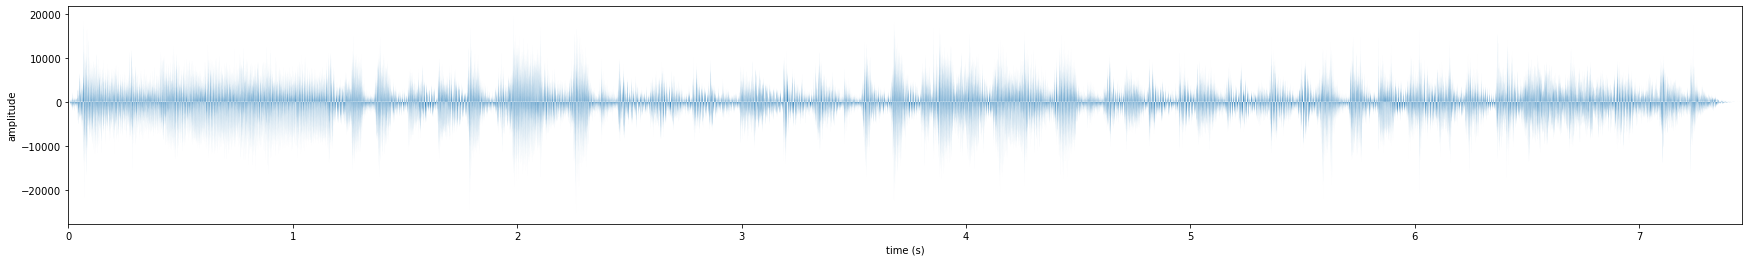

In [10]:
timestep = 1/float(Fs)*2./3.
times = np.arange(len(z))*timestep

plot_sound(z,times)

In [49]:
write('new_caravan.wav', 32000, np.array(z, dtype=np.int16)) # to write a new wave file

data_path = os.getcwd()
filename = 'new_caravan.wav'
sound = os.path.join(data_path, filename) 

play = False
if play :
    play_sound(sound)


In [40]:
## Question 3 #################

t0 = time.time()  # used for question 4

## Two successive polyphase decompositions
r1 = h[::2]
r0 = h[1::2]
e00 = r0[::3]
e01 = r0[1::3]
e02 = r0[2::3]
e10 = r1[::3]
e11 = r1[1::3]
e12 = r1[2::3]

## Back and forth-shifting of the input + zero-padding, then decimation
x00 = np.concatenate((x, np.zeros(1), np.zeros(3)))[1:len(x)+2:3]
x01 = np.concatenate((x, np.zeros(3)))[0:len(x)+1:3]
x02 = np.concatenate((np.zeros(1), x, np.zeros(3)))[0:len(x)+1:3]
x10 = x01
x11 = x02
x12 = np.concatenate((np.zeros(2), x, np.zeros(3)))[0:len(x)+1:3]

## Convolution of the decimated signals with the phase filters
y00 = sgn.lfilter(e00, 1, x00)
y01 = sgn.lfilter(e01, 1, x01)
y02 = sgn.lfilter(e02, 1, x02)
y10 = sgn.lfilter(e10, 1, x10)
y11 = sgn.lfilter(e11, 1, x11)
y12 = sgn.lfilter(e12, 1, x12)

## Addition of the signals which was filtered by the same phase of the first decomposition
z0 = y00 + y01 + y02
z1 = y10 + y11 + y12

## Insertion of zeros in each obtained signal
z0_insert = np.zeros(2*len(z0))
z0_insert[0:len(z0_insert):2] = z0

z1_insert = np.zeros(2*len(z1))
z1_insert[0:len(z1_insert):2] = z1

## Forth-shifting of z0_insert
z0_insert_shifted = np.concatenate((np.zeros(1), z0_insert))[0:len(z0_insert)]

## Addition of the two signals to get the final output signal

z_new = z0_insert_shifted + z1_insert

t1 = time.time()  # used for question 4
print("running time of polyphase decomposition implementation : ", t1-t0)  #computation of running time

running time of polyphase decomposition implementation :  0.06360125541687012


In [42]:
write('new_caravan2.wav', 32000, np.array(z_new, dtype=np.int16)) # to write a new wave file

data_path = os.getcwd()
filename = 'new_caravan2.wav'
sound = os.path.join(data_path, filename) 

play = False
if play :
    play_sound(sound)

## Signal analysis with the STFT

In [68]:
N = x.shape[0] # % longueur du signal
Nw = 512
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = Nw/4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 512 # ordre de la tfd
L = M/2+1
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

<ipython-input-57-5a9daa21cd83>:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.linspace(0,1,M,endpoint=False),20*np.log10(abs(np.fft.fft(w,M))))


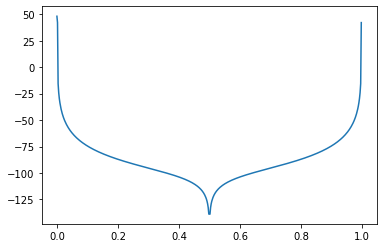

In [57]:
## Question 1 #########

plt.plot(np.linspace(0,1,M,endpoint=False),20*np.log10(abs(np.fft.fft(w,M))))

In [58]:
for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add
    


def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

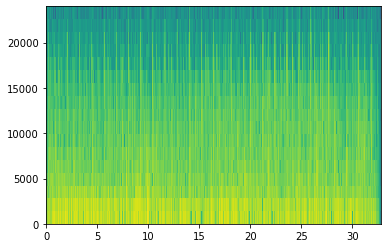

In [63]:
## Question 3 #########

N = x.shape[0] # % longueur du signal
Nw = 32
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = 1 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 32 # ordre de la tfd
L = M/2+1
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)
    
for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

if affich:
    plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0,int(L)),:])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])

In [64]:
write('stft.wav', 48000, np.array(np.real(Xtilde[3]), dtype=np.int16)) # we write a new wave file

data_path = os.getcwd()
filename = 'stft.wav'
sound = os.path.join(data_path, filename) 

In [67]:
play = True
if play :
    play_sound(sound) ## listen to the filtered signal (question 3)

## Overlap-add reconstruction

In [87]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

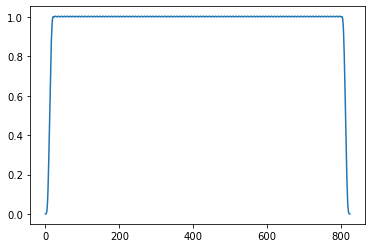

In [104]:
## Question 4 #########

w = np.hanning(32)
plt.plot(ola(w*w/1.45,8,100))

In [100]:
## Question 5 #########

def reconstruction(Xtilde):
    y = np.zeros(Xtilde.shape[1])
    for n in range (Xtildeee.shape[1]):
        for u in range (n - Nw + 1, n + 1):
            y[n] += np.fft.ifft(Xtilde[:,u])[n-u] * w[n-u]
    return y

In [ ]:
reconst = reconstruction(Xtilde)

In [ ]:
write('reconst.wav', 48000, np.array(reconst, dtype=np.int16)) # we write a new wave file

data_path = os.getcwd()
filename = 'reconst.wav'
sound = os.path.join(data_path, filename)

play = True
if play :
    play_sound(sound) ## listen to the reco,struction signal (question 5)